# **- Pipeline crack detection -**

# **UNET-V2**

Tiene todas las caracteristicas implementadas, pero no es capaz de predecir nada de manera correcta.

# **0. Libraries**

### Installing libraries

In [ ]:
print("Installing segmentation_models....")
!pip install segmentation_models --quiet
print("  -> segmentation_models installed!")

print("Installing patchify....")
!pip install patchify --quiet
print("  -> patchify installed!")

print("\n" + '\033[1m' + "Libraries correctly installed!" + '\033[0m')

Installing segmentation_models....
  -> segmentation_models installed!
Installing patchify....
  -> patchify installed!

Libraries correctly installed!


### Importing libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np

%env SM_FRAMEWORK = tf.keras
import segmentation_models as sm

from sklearn.model_selection import train_test_split
import random

from keras.preprocessing.image import ImageDataGenerator

from patchify import patchify, unpatchify
import tifffile as tiff



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


# **1. Auxiliar functions**

In [ ]:
class printing_format:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   bold = '\033[1m'
   underline = '\033[4m'
   end = '\033[0m'

format = printing_format()

def resize_images( input_images, x, y, z ):

  input_images = np.array( input_images )

  size = len( input_images )
  dim = (x, y)

  output_images = []

  for i in range(0, size):
    img = input_images[i]
    img = cv2.resize(img, dim, interpolation= cv2.INTER_LINEAR)
    if z == 1: img = img[:, :, 0]
    output_images.append( img )

  output_images = np.array( output_images )
  
  return output_images

def crop_images (img_in, crop_size):
  
  crop = int(img_in.shape[1] / crop_size)
  crops = pow(crop, 2)

  # print("Crop:  \t" + str(crop) )
  # print("Crops: \t" + str(crops) )

  img_out = np.zeros( (img_in.shape[0] * crops, crop_size, crop_size))

  n = 0

  for i in range( img_in.shape[0] ):

    patch = patchify(img_in[i], (crop_size, crop_size), step = crop_size)

    for j in range( crop ):
      for k in range( crop ):

        n = i * crops + j * crop + k

        img_out[n] = patch[j, j, :, :]

  return img_out

def clone_layer (img_in, layers):

  img = np.zeros( (img_in.shape[0], img_in.shape[1], img_in.shape[2], layers) )

  for i in range( layers ): img[:, :, :, i] = img_in

  return img

# **2. DataSet generation**

### 2.1. Import images

In [ ]:
%cd '/content/drive/MyDrive/PBL-SecondSemester/DeepLearning/DataSet'
print()
!ls

/content/drive/.shortcut-targets-by-id/1LFMENSUeZANGJsWPtbb3BcvK4y9YdVWF/PBL-SecondSemester/DeepLearning/DataSet

Onak  Txarrak  unet


In [ ]:
## Importing good ones

print(format.bold + " -- GOOD IMAGES --\n" + format.end)

files = os.listdir( "Onak" )

print("Files in directory:\t" + str(len( files )))

good_img = []

for file in files:
  good_img.append( cv2.imread("Onak/" + file ) )

print("Imported images: \t" + str(len( good_img )))


## Importing wrong ones

print(format.bold + "\n -- WRONG IMAGES --\n" + format.end)

files = os.listdir( "Txarrak" )

print("Files in directory:\t" + str(len( files )))

files = sorted(files)

wrong_img = []
wrong_roi = []

for file in files:
  img = cv2.imread( "Txarrak/" + file )

  if file.endswith("_ROI.bmp"):
    wrong_roi.append( img )
  else:
    wrong_img.append( img )

print("Imported data:")
print("  -> Images: \t\t" + str(len( wrong_img )))
print("  -> ROI:    \t\t" + str(len( wrong_roi )))

print(format.bold + "\n -- IMAGES SIZE --\n" + format.end)
print("  Good images: \t" + str( good_img[0].shape ) )
print("  Wrong images:\t" + str( wrong_img[0].shape ) )
print("  ROI images:  \t" + str( wrong_roi[0].shape ) )

 -- GOOD IMAGES --

Files in directory:	150
Imported images: 	150

 -- WRONG IMAGES --

Files in directory:	290
Imported data:
  -> Images: 		145
  -> ROI:    		145

 -- IMAGES SIZE --

  Good images: 	(942, 944, 3)
  Wrong images:	(943, 923, 3)
  ROI images:  	(943, 923, 3)


### 2.2. Format of the images


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



Resized data:
  Good images: 	(150, 320, 320, 3)
  Wrong images:	(145, 320, 320, 3)
  ROI images:  	(145, 320, 320)



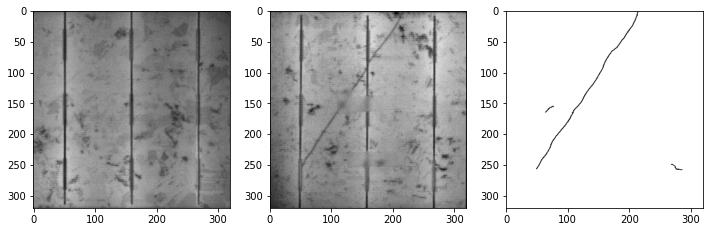

In [ ]:
x_size = 64 * 5
y_size = x_size

good_img  = np.array( resize_images( good_img, x_size, y_size, 0 ), dtype = 'int16' )
wrong_img = np.array( resize_images( wrong_img, x_size, y_size, 0 ), dtype = 'int16' )

img = []
for i in range(0, len(wrong_roi)):
  img.append( cv2.cvtColor(wrong_roi[i], cv2.COLOR_BGR2GRAY) )
wrong_roi = np.array( resize_images( img, x_size, y_size, 0 ), dtype = ('int16') )

print()
print(format.bold + "Resized data:" + format.end)
print("  Good images: \t" + str( good_img.shape ) )
print("  Wrong images:\t" + str( wrong_img.shape ) )
print("  ROI images:  \t" + str( wrong_roi.shape ) )
print()

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow( good_img[1, :, :, 0], cmap = "gray" )
plt.subplot(132)
plt.imshow( wrong_img[52, :, :, 0], cmap = "gray" )
plt.subplot(133)
plt.imshow( wrong_roi[52], cmap = "gray" )
plt.show()

### 2.3. Generate good images ROI

Resized data:
  Good images: 	(150, 320, 320, 3)
  Good ROI:    	(150, 320, 320)
  Wrong images:	(145, 320, 320, 3)
  Wrong ROI:   	(145, 320, 320)



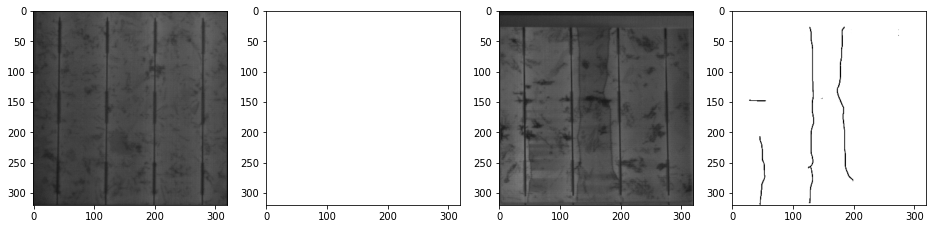

In [ ]:
good_roi = np.ones( good_img.shape[:-1], dtype = 'int16' ) * 255
good_roi[:, 1, 1] = 254

print(format.bold + "Resized data:" + format.end)
print("  Good images: \t" + str( good_img.shape ) )
print("  Good ROI:    \t" + str( good_roi.shape ) )
print("  Wrong images:\t" + str( wrong_img.shape ) )
print("  Wrong ROI:   \t" + str( wrong_roi.shape ) )
print()

index = random.randint(0, len(wrong_img) - 1)

plt.figure(figsize=(16, 6))
plt.subplot(141)
plt.imshow( good_img[index])
plt.subplot(142)
plt.imshow( good_roi[index], cmap = "gray")
plt.subplot(143)
plt.imshow( wrong_img[index])
plt.subplot(144)
plt.imshow( wrong_roi[index], cmap = "gray" )
plt.show()

### 2.4. Crop images

Croped data:
  Good images: 	(3750, 64, 64, 3)
  Good ROI:    	(3750, 64, 64)
  Wrong images:	(3625, 64, 64, 3)
  Wrong ROI:   	(3625, 64, 64)



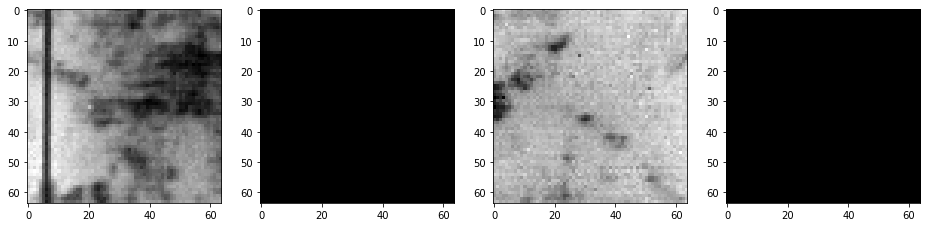

In [ ]:
crop_size = 64

good_img = crop_images( good_img[:, :, :, 0], crop_size )
good_img = clone_layer( good_img, 3 )

wrong_img = crop_images( wrong_img[:, :, :, 0], crop_size )
wrong_img = clone_layer( wrong_img, 3 )

good_roi  = crop_images( good_roi, crop_size )

wrong_roi = crop_images( wrong_roi, crop_size )


print(format.bold + "Croped data:" + format.end)
print("  Good images: \t" + str( good_img.shape ) )
print("  Good ROI:    \t" + str( good_roi.shape ) )
print("  Wrong images:\t" + str( wrong_img.shape ) )
print("  Wrong ROI:   \t" + str( wrong_roi.shape ) )
print()

index = random.randint(0, len(wrong_img) - 1)

plt.figure(figsize=(16, 6))
plt.subplot(141)
plt.imshow( good_img[index, :, :, 0] / 255, cmap = "gray" )
plt.subplot(142)
plt.imshow( good_roi[index], cmap = "gray")
plt.subplot(143)
plt.imshow( wrong_img[index, :, :, 0] / 255, cmap = "gray" )
plt.subplot(144)
plt.imshow( wrong_roi[index], cmap = "gray" )
plt.show()

### 2.5. Normalize values

In [ ]:
print(format.bold + "Splited data:" + format.end)
print("  Good images:  \t" + str( good_img.shape ) + "\t - " + str( good_img.dtype ) )
print("  Good ROI:     \t" + str( good_roi.shape ) + "\t\t - " + str( good_roi.dtype ) )
print("  Wrong images: \t" + str( wrong_img.shape ) + "\t - " + str( wrong_img.dtype ) )
print("  Wrong ROI:    \t" + str( wrong_roi.shape ) + "\t\t - " + str( wrong_roi.dtype ) )

index = random.randint(0, len(good_img) - 1)

print("\n" + format.bold + "Max-Min (" + str(index) + "):" + format.end)
print("  Good images:  \t" + str( good_img[index, :, :, 0].min() ) + "\t-\t"  + str( good_img[index, :, :, 0].max() ) )
print("  Good ROI:     \t" + str( good_roi[index, :, :].min() ) + "\t-\t"  + str( good_roi[index, :, :].max() ) )
print("  Wrong images: \t" + str( wrong_img[index, :, :, 0].min() ) + "\t-\t"  + str( wrong_img[index, :, :, 0].max() ) )
print("  Wrong ROI:    \t" + str( wrong_roi[index, :, :].min() ) + "\t-\t"  + str( wrong_roi[index, :, :].max() ) )

Splited data:
  Good images:  	(3750, 64, 64, 3)	 - float64
  Good ROI:     	(3750, 64, 64)		 - float64
  Wrong images: 	(3625, 64, 64, 3)	 - float64
  Wrong ROI:    	(3625, 64, 64)		 - float64

Max-Min (3125):
  Good images:  	31.0	-	86.0
  Good ROI:     	254.0	-	255.0
  Wrong images: 	17.0	-	99.0
  Wrong ROI:    	0.0	-	255.0


In [ ]:
dataset_x1 = good_img / 255
dataset_x2  = wrong_img / 255
dataset_y1 = good_roi > 20
dataset_y2 = wrong_roi > 20

data_type = "float32"
dataset_x1 = dataset_x1.astype( data_type )   # good_img
dataset_x2 = dataset_x2.astype( data_type )   # wrong_img
dataset_y1 = dataset_y1.astype( data_type )   # good_roi
dataset_y2 = dataset_y2.astype( data_type )   # wrong_roi

# dataset_x = np.concatenate( (dataset_x1, dataset_x2) )
# dataset_y = np.concatenate( (dataset_y1, dataset_y2) )

dataset_x = dataset_x2
dataset_y = dataset_y2

del dataset_x1
del dataset_x2
del dataset_y1
del dataset_y2

In [ ]:
index = random.randint(0, len(dataset_x) - 1)

print("\n" + format.bold + "Dataset format (" + str(index) + "):" + format.end)
print("  X dataset: \t" + str( dataset_x.shape ) + "  - "    + str( good_img.dtype ) + "  / "    + str( dataset_x[index, :, :, 0].min() ) + " - "  + str( dataset_x[index, :, :, 0].max() ) )
print("  Y dataset: \t" + str( dataset_y.shape ) + "     - " + str( good_img.dtype ) + "  / " + str( dataset_y[index, :, :].min() ) + " - "  + str( dataset_y[index, :, :].max() ) )


Dataset format (1009):
  X dataset: 	(3625, 64, 64, 3)  - float64  / 0.16862746 - 0.41568628
  Y dataset: 	(3625, 64, 64)     - float64  / 0.0 - 1.0


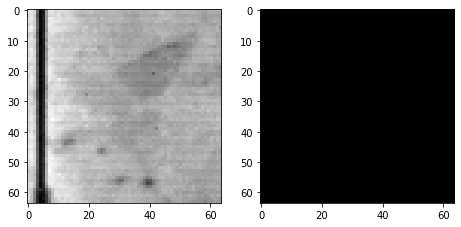

In [ ]:
index = random.randint(0, len(good_img) - 1)

plt.figure(figsize=(16, 6))
plt.subplot(141)
plt.imshow( dataset_x[index, :, :, 0], cmap = "gray" )
plt.subplot(142)
plt.imshow( dataset_y[index], cmap = "gray")
# plt.subplot(143)
# plt.imshow( dataset_x[index + len(good_img) - 1])
# plt.subplot(144)
# plt.imshow( dataset_y[index + len(good_img) - 1], cmap = "gray" )
plt.show()

### 2.6. Split dataset

Splited data:
  x_train: 	(3262, 64, 64, 3)	 - float32
  y_train: 	(3262, 64, 64)		 - float32
  x_test:  	(363, 64, 64, 3)		 - float32
  y_test:  	(363, 64, 64)		 - float32

Max-Min (5):
  x_train: 	0.21960784 - 0.40784314
  x_test:  	0.13333334 - 0.34509805
  y_train: 	1.0 - 1.0
  y_test:  	1.0 - 1.0

Index: 	5


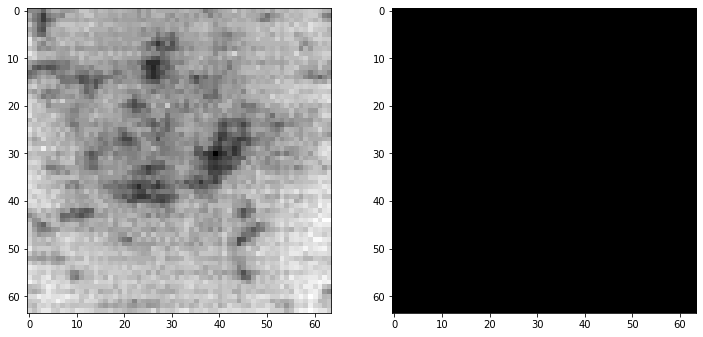

In [ ]:
test_size = 0.1

x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size = test_size, random_state = 0)

print(format.bold + "Splited data:" + format.end)
print("  x_train: \t" + str( x_train.shape ) + "\t - " + str( x_train.dtype ) )
print("  y_train: \t" + str( y_train.shape ) + "\t\t - " + str( y_train.dtype ) )
print("  x_test:  \t" + str( x_test.shape ) + "\t\t - " + str( x_test.dtype ) )
print("  y_test:  \t" + str( y_test.shape ) + "\t\t - " + str( y_test.dtype ) )

index = random.randint(0, len(x_test) - 1)

print("\n" + format.bold + "Max-Min (" + str(index) + "):" + format.end)
print( "  x_train: \t" + str( x_train[index, :, :, 0].min() ) + " - "  + str( x_train[index, :, :, 0].max() ) )
print( "  x_test:  \t" + str( x_test[index, :, :, 0].min() ) + " - "  + str( x_test[index, :, :, 0].max() ) )
print( "  y_train: \t" + str( y_train[index, :, :].min() ) + " - "  + str( y_train[index, :, :].max() ) )
print( "  y_test:  \t" + str( y_test[index, :, :].min() ) + " - "  + str( y_test[index, :, :].max() ) )

print("\n" + format.bold + "Index: \t" + format.end + str(index) )
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow( x_train[index, :, :, 0], cmap = "gray" )
plt.subplot(122)
plt.imshow( y_train[index], cmap = "gray" )
plt.show()

# **3. Define UNET model**

### 3.1. Trainning the model

In [ ]:
# Paremeters

BACKBONE = 'resnet50'
encoder = 'imagenet'

epoch = 12
batch_size = 16
steps = 50

In [ ]:
if BACKBONE == "resnet34": k_time = 150/50
if BACKBONE == "resnet50": k_time = 14*60/120

if steps != False:
  epoch_time = steps * k_time
  batch_size = int(x_train.shape[0] / steps)
else:
  epoch_time = x_train.shape[0] / batch_size * k_time
  steps = int(x_train.shape[0] / batch_size)

total_time = epoch_time * epoch

print(format.bold + "=================================" + format.end)
print(format.bold + "\t- MODEL SUMMARY -" + format.end)
print(format.bold + "=================================" + format.end)
print(format.bold + "Images size: \t\t" + format.end + str(x_size))
print(format.bold + "Crops:       \t\t" + format.end + str(int(x_size / 64)) + "x" + str(int(x_size / 64)) )
print(format.bold + "Train size:  \t\t" + format.end + str(x_train.shape[0]))
print(format.bold + "=================================" + format.end)
print(format.bold + "Backbone:         \t" + format.end + str(BACKBONE))
print(format.bold + "Encoder_weights:  \t" + format.end + str(encoder))
print(format.bold + "Epochs:           \t" + format.end + str(epoch))
print(format.bold + "Steps per epoch:  \t" + format.end + str(steps))
print(format.bold + "Batch size:       \t" + format.end + str(batch_size))
print(format.bold + "Time per epoch:   \t" + format.end + str(int(epoch_time / 60)) + " min")
print(format.bold + "Total train time: \t" + format.end + str(int(total_time / 60)) + " min")
print(format.bold + "=================================" + format.end)

	- MODEL SUMMARY -
Images size: 		320
Crops:       		5x5
Train size:  		3262
Backbone:         	resnet50
Encoder_weights:  	imagenet
Epochs:           	12
Steps per epoch:  	50
Batch size:       	65
Time per epoch:   	5 min
Total train time: 	70 min


In [ ]:
preprocess_input1 = sm.get_preprocessing(BACKBONE)
model = sm.Unet(BACKBONE, encoder_weights = encoder)
model.compile('Adam', loss = sm.losses.bce_jaccard_loss, metrics = [sm.metrics.iou_score])
# print( model.summary() )
if steps != False:
  history = model.fit(x = x_train, y = y_train, validation_data = (x_test, y_test), epochs = epoch, steps_per_epoch = steps)
else:
  history = model.fit(x = x_train, y = y_train, validation_data = (x_test, y_test), epochs = epoch, batch_size = batch_size)

Epoch 1/12
50/50 [==============================] - 820s 16s/step - loss: 0.7367 - iou_score: 0.6855 - val_loss: 0.2045 - val_iou_score: 0.9286
Epoch 2/12
50/50 [==============================] - 795s 16s/step - loss: 0.1462 - iou_score: 0.9331 - val_loss: 0.3534 - val_iou_score: 0.8346
Epoch 3/12
50/50 [==============================] - 790s 16s/step - loss: 0.0667 - iou_score: 0.9732 - val_loss: 0.1431 - val_iou_score: 0.9375
Epoch 4/12
50/50 [==============================] - 783s 16s/step - loss: 0.0484 - iou_score: 0.9822 - val_loss: 0.0905 - val_iou_score: 0.9660
Epoch 5/12
50/50 [==============================] - 782s 16s/step - loss: 0.0387 - iou_score: 0.9866 - val_loss: 0.0696 - val_iou_score: 0.9792
Epoch 6/12
50/50 [==============================] - 781s 16s/step - loss: 0.0301 - iou_score: 0.9898 - val_loss: 0.0622 - val_iou_score: 0.9852
Epoch 7/12
50/50 [==============================] - 781s 16s/step - loss: 0.0251 - iou_score: 0.9914 - val_loss: 0.0607 - val_iou_score:

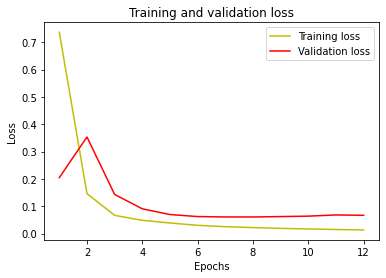

In [ ]:
# Plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

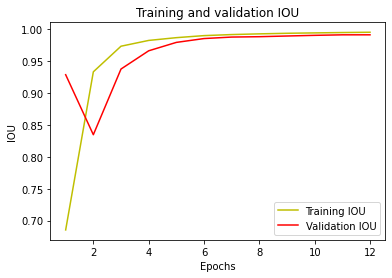

In [ ]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# Save model results

%cd '/content/drive/MyDrive/PBL-SecondSemester/DeepLearning/model_data'

model_name = datetime.now()
model_name = datetime.strftime(model_name, "%Y-%m-%d_%H-%M-%S")
model_name = str( model_name ) + "_unet_model"

print(format.bold + "UNET file: \t" + format.end + model_name)

model.save( model_name )

/content/drive/.shortcut-targets-by-id/1LFMENSUeZANGJsWPtbb3BcvK4y9YdVWF/PBL-SecondSemester/DeepLearning/model_data
UNET file: 	2022-05-26_11-58-26_unet_model
INFO:tensorflow:Assets written to: 2022-05-26_11-58-26_unet_model/assets


### 3.2. Checking results

In [ ]:
## Importing good ones

%cd '/content/drive/MyDrive/PBL-SecondSemester/DeepLearning/DataSet'

print("Importing data...")

files = os.listdir( "Onak" )

good_img = []

for file in files:
  good_img.append( cv2.imread("Onak/" + file ) )

files = os.listdir( "Txarrak" )

files = sorted(files)

wrong_img = []
wrong_roi = []

for file in files:
  img = cv2.imread( "Txarrak/" + file )

  if file.endswith("_ROI.bmp"):
    wrong_roi.append( img )
  else:
    wrong_img.append( img )

print("  -> Data imported")

print("Scaling images...")
good_img  = np.array( resize_images( good_img, x_size, y_size, 0 ), dtype = 'int16' )
wrong_img = np.array( resize_images( wrong_img, x_size, y_size, 0 ), dtype = 'int16' )

img = []
for i in range(0, len(wrong_roi)):
  img.append( cv2.cvtColor(wrong_roi[i], cv2.COLOR_BGR2GRAY) )
wrong_roi = np.array( resize_images( img, x_size, y_size, 0 ), dtype = ('int16') )

print("  -> Images scaled")

/content/drive/.shortcut-targets-by-id/1LFMENSUeZANGJsWPtbb3BcvK4y9YdVWF/PBL-SecondSemester/DeepLearning/DataSet
Importing data...
  -> Data imported
Scaling images...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


  -> Images scaled


In [ ]:
def make_prediction (img_in, model):

  # Define internal parameters
  crop_size = 64

  # Calculate parameters
  img_size = img_in.shape[0]
  crop = int(img_size / crop_size)
  crops = int( pow(crop, 2) )

  # Generate patchs
  patch = patchify(img_in[:, :, 0], (64, 64), step = 64)

  # Define model input array 
  dec = np.zeros( (crops, 64, 64, 3), dtype = img_in.dtype )

  # Format change
  for i in range( crop ):
    for j in range( crop ):
      n = i * crop + j
      for channel in range( 3 ):
        dec[n, :, :, channel] = patch[i, j, :, :]

  ##### MODEL #####
  result = model.predict( dec )
  #################

  # Define output image
  rec = np.zeros( (img_in.shape[0], img_in.shape[1], 1), dtype = img_in.dtype )

  # Reconstruct image
  n = 0

  for i in range( crop ):
    for j in range( crop ):

      x1 = i * crop_size
      x2 = (i + 1) * crop_size

      y1 = j * crop_size
      y2 = (j + 1) * crop_size

      rec[x1:x2 , y1:y2] = result[n]
      n = n + 1

  # Channels problem
  rec = rec[:, :, 0]

  return rec

0. Index:  70


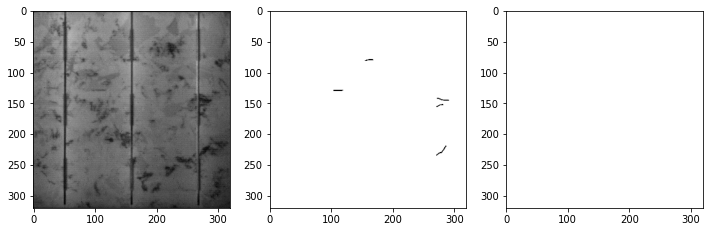

1. Index:  0


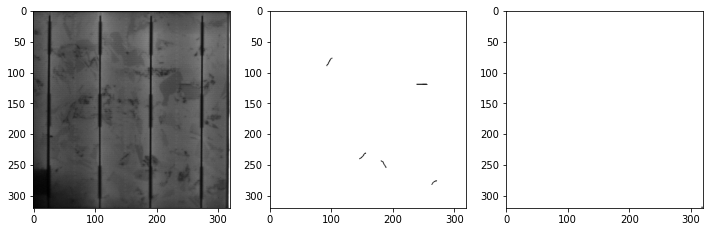

2. Index:  115


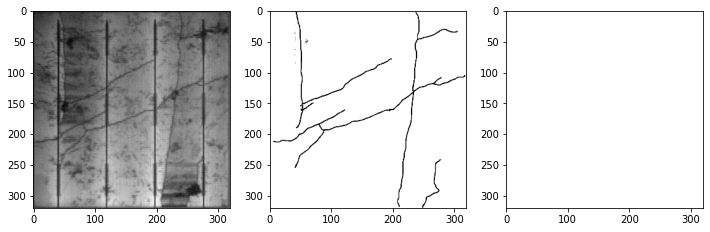

3. Index:  109


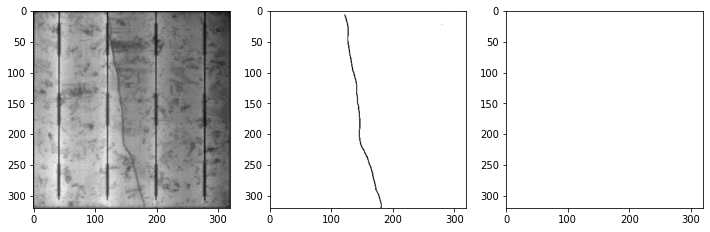

4. Index:  63


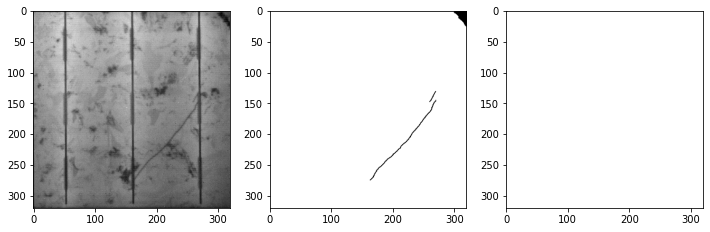

5. Index:  36


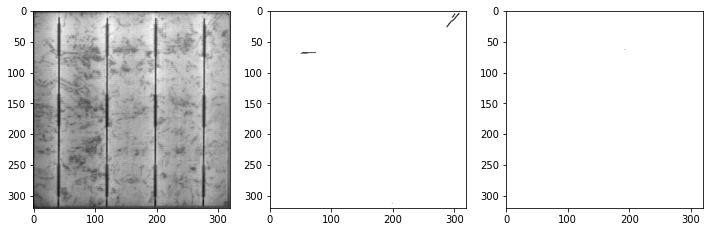

6. Index:  90


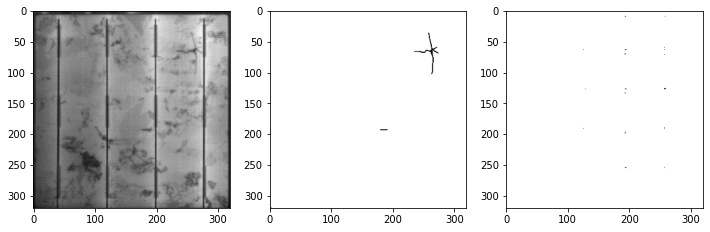

7. Index:  37


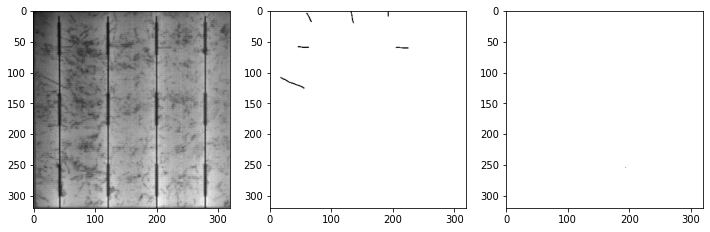

8. Index:  91


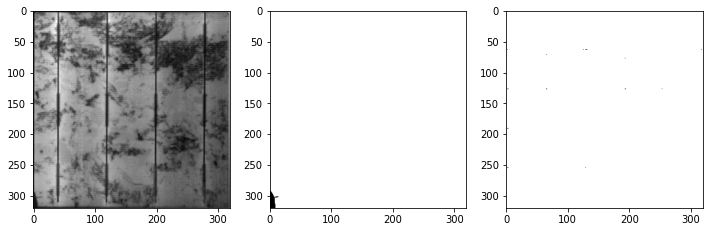

9. Index:  70


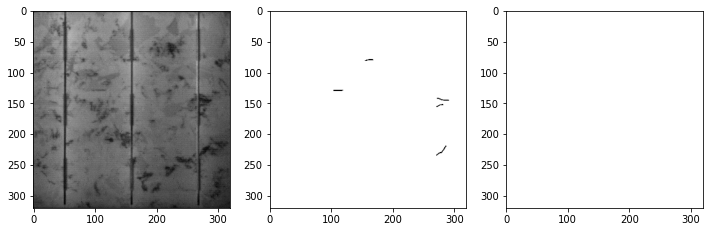

10. Index:  109


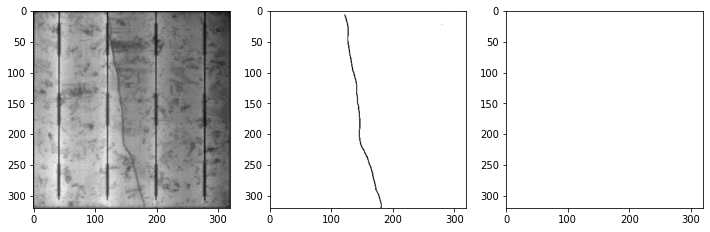

11. Index:  135


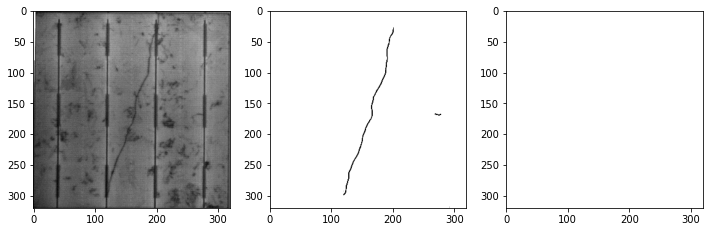

12. Index:  82


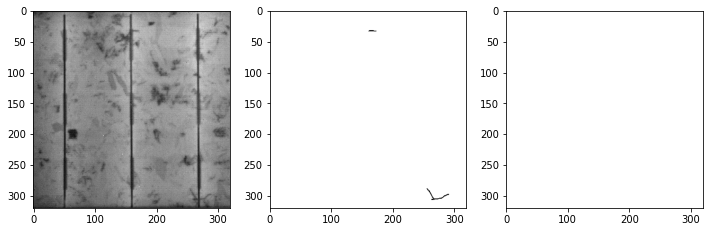

13. Index:  48


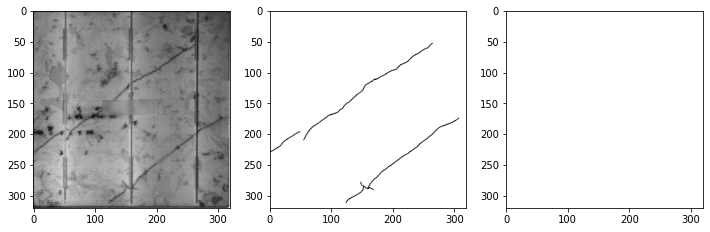

14. Index:  8


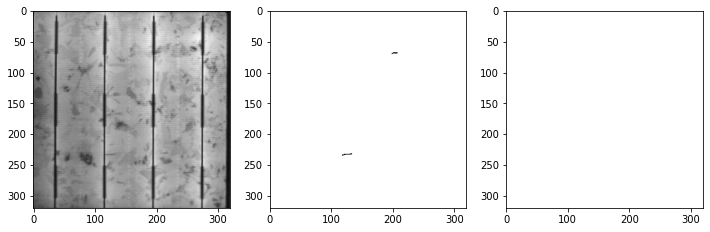

15. Index:  13


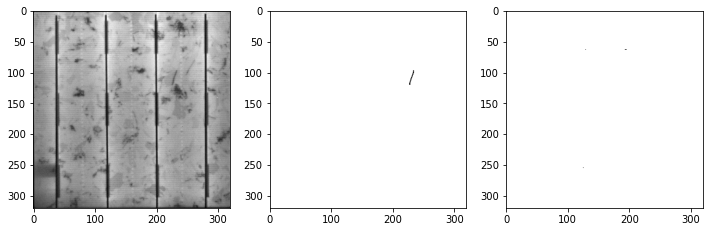

16. Index:  106


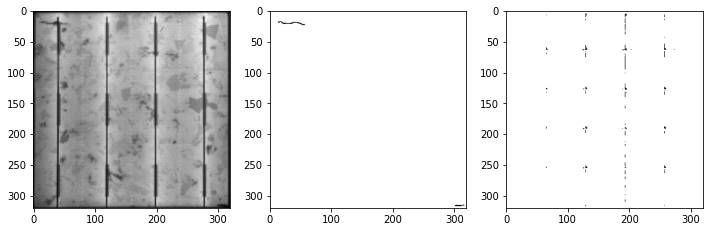

17. Index:  14


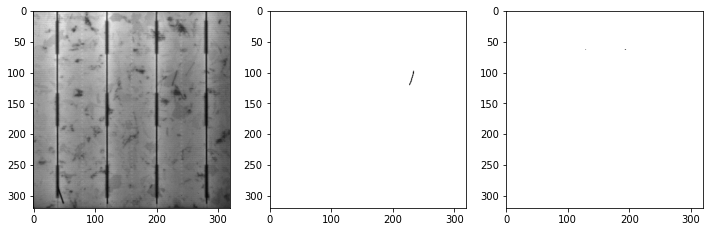

18. Index:  111


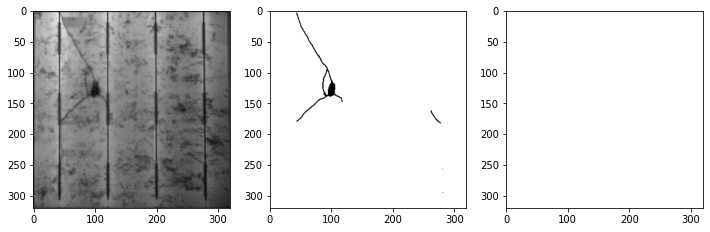

19. Index:  61


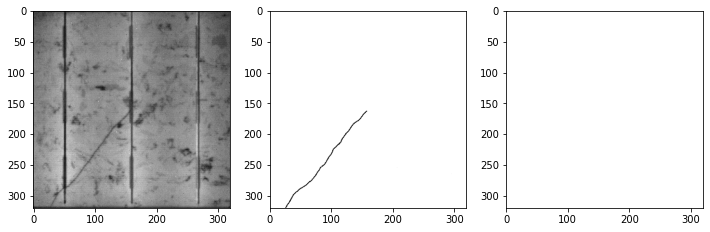

In [ ]:
for i in range( 20 ):

  index = random.randint(0, len(wrong_img) - 1)

  result = make_prediction(wrong_img[index], model)

  result[0, 0] = 0
  result[0, 1] = 0.5
  result[0, 2] = 1
  result = ~result * 255

  print(format.bold + str(i) + ". Index:  " + format.end + str(index))
  plt.figure(figsize=(12, 6))
  plt.subplot(131)
  plt.title = format.bold + "Input image" + format.end
  plt.imshow( wrong_img[index, :, :, 0], cmap = "gray")
  plt.subplot(132)
  plt.title = format.bold + "ROI" + format.end
  plt.imshow( wrong_roi[index], cmap = "gray")
  plt.subplot(133)
  plt.title = format.bold + "Model" + format.end
  plt.imshow( result,cmap = "gray" )
  plt.show()

# **4. Output processing**

# **5. Evaluate results**